In [14]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

This notebook refers to the "Home Credit Default Risk" Kaggle competition. The competition is about predicting future payment behavior of clients from application, demographic and historical credit behavior data. 

Check files in the input directory

In [2]:
print(os.listdir("input"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv.zip', 'POS_CASH_balance.csv.zip', 'previous_application.csv', 'sample_submission.csv.zip']


We will be having a look first at application_train.csv file. 
The application_train.csv table, together with the application_test.csv dataset, is the main table. The target variable is called TARGET, a binary variable. These are the main train and test samples. They contain info about loan and loan applicant at application time.
This is static data for all applications. One row represents one loan in the data sample
The TARGET variable is described as: "1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases"

Load and inspect dataset.

In [2]:
application_train = pd.read_csv('input/application_train.csv')

In [3]:
application_train.shape

(307511, 122)

The pandas_profiling library has utilities to create very quick reports for dataset overview. It even warns you about variables with too many zeros, or correlated variables.

In [6]:
profile_application_train = pandas_profiling.ProfileReport(application_train)
profile_application_train.to_file(outputfile='EDA/application_train.profile.html')

Some interesting variables are DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION and DAYS_ID_PUBLISH. These are continuous variables but they are in general expressed as negative values.  
DAYS_BIRTH for example is explained as "Client's age in days at the time of application,time only relative to the application". So it is all negative values. I do not understand this way of presenting data, never seen it before.
Let's have a look at its histogram and some descriptives

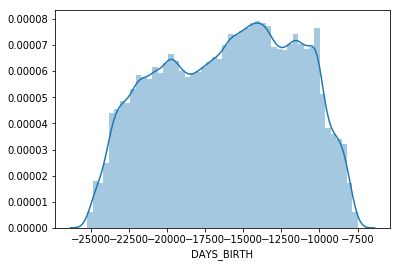

In [42]:
sns.distplot(application_train.DAYS_BIRTH);

In [7]:
pd.set_option('precision', 3)
(application_train.DAYS_BIRTH/-365.25).describe()#365.25 approximation for leap years
#So the youngest person in the database is 20 and a half years old, and the oldest is 69 years old

count    307511.000
mean         43.907
std          11.948
min          20.504
25%          33.985
50%          43.121
75%          53.886
max          69.073
Name: DAYS_BIRTH, dtype: float64

Right, so let's compare TARGET with age, i.e. DAYS_BIRTH

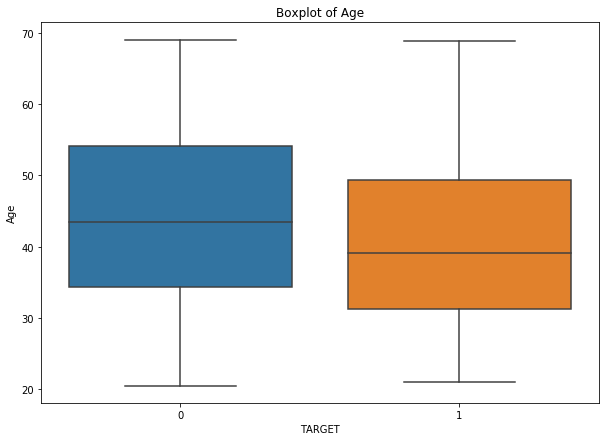

In [12]:
#Transform days_birth to years
age = application_train.DAYS_BIRTH/-365.25
fig, ax = plt.subplots(figsize=(10,7))
bpl=sns.boxplot(ax=ax, x="TARGET",y=age,data=application_train)
bpl.set_xticklabels(ax.get_xticklabels())
bpl.set_title('Boxplot of Age')
bpl.set_ylabel('Age');

So it seems that clients that fail to pay back the loans tend to be younger than those who are able to pay back

DAYS_EMPLOYED is another interesting variable. It is negative by definition. But it has some values that denote missing values
From the discussion: 'Value 365243 denotes infinity in DAYS variables in the datasets, therefore you can consider them NA values.' So we should do that before looking at the distribution.

In [27]:
application_train.DAYS_EMPLOYED.replace(365243,np.NaN,inplace=True)#overwrites the df
application_train.DAYS_EMPLOYED.describe()

count    252137.000
mean      -2384.169
std        2338.360
min      -17912.000
25%       -3175.000
50%       -1648.000
75%        -767.000
max           0.000
Name: DAYS_EMPLOYED, dtype: float64

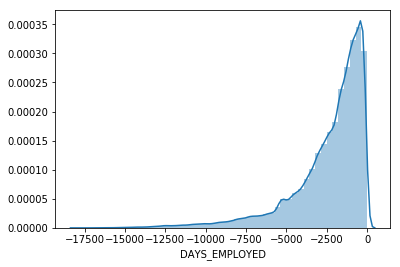

In [43]:
sns.distplot(application_train['DAYS_EMPLOYED'].dropna());

We can have a look at days employed and OCCUPATION_TYPE, to see if there is something interesting there. We can also have a look at the relationship between the TARGET variable and these two employment variables. One could assume that the longer you have been employed, the more chances to pay the credit.

In [10]:
application_train.OCCUPATION_TYPE.value_counts()

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

Lets do a Two-way table

In [15]:
#OCCUPATION_TYPE by TARGET
occType_Target = pd.crosstab(index=application_train.TARGET, 
                           columns=application_train.OCCUPATION_TYPE,
                            margins=True)

occType_Target.index= ["All other cases","Payment Difficulties","ColTotal"]

occType_Target

OCCUPATION_TYPE,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff,All
All other cases,9339,4206,5325,25832,16496,527,10679,492,49348,1734,20043,7965,2477,692,29010,1213,5999,1196,192573
Payment Difficulties,474,447,621,1738,2107,36,701,34,5838,359,1328,572,175,59,3092,92,722,152,18547
ColTotal,9813,4653,5946,27570,18603,563,11380,526,55186,2093,21371,8537,2652,751,32102,1305,6721,1348,211120


In [17]:
#Get the proportions
occType_Target/occType_Target.loc["ColTotal"]



OCCUPATION_TYPE,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff,All
All other cases,0.951697,0.903933,0.89556,0.93696,0.886739,0.936057,0.938401,0.935361,0.894212,0.828476,0.93786,0.932998,0.934012,0.921438,0.903682,0.929502,0.892576,0.88724,0.912149
Payment Difficulties,0.048303,0.096067,0.10444,0.06304,0.113261,0.063943,0.061599,0.064639,0.105788,0.171524,0.06214,0.067002,0.065988,0.078562,0.096318,0.070498,0.107424,0.11276,0.087851
ColTotal,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


It seems the Low-skill Laborers are those who get more difficulties at paying credits back, followed by drivers and waiters/barmen staff. Accountants, on the other hand have the lowest level of non-payment risk.

Lets have a look at a boxplot of days employed for each category.

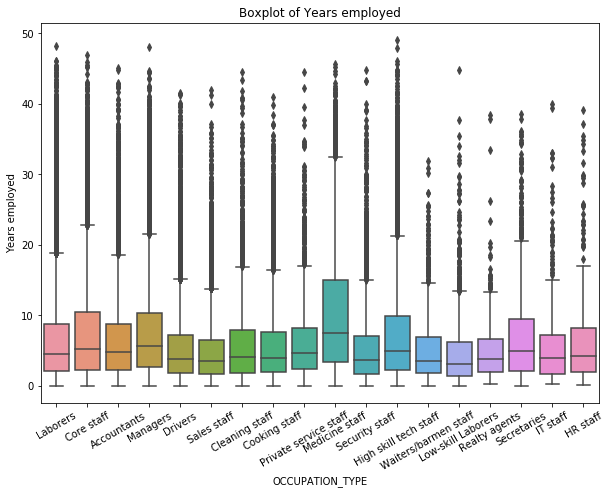

In [10]:
#Transform days_employed to years
years_employed = application_train.DAYS_EMPLOYED/-365.25
fig, ax = plt.subplots(figsize=(10,7))
bpl=sns.boxplot(ax=ax, x="OCCUPATION_TYPE",y=years_employed,data=application_train)
bpl.set_xticklabels(ax.get_xticklabels(),rotation=30)
bpl.set_title('Boxplot of Years employed')
bpl.set_ylabel('Years employed');

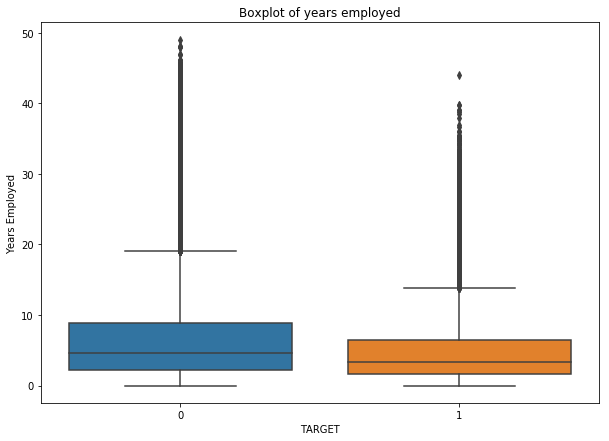

In [11]:
fig, ax = plt.subplots(figsize=(10,7))
bpl=sns.boxplot(ax=ax, x="TARGET",y=years_employed,data=application_train)
bpl.set_xticklabels(ax.get_xticklabels())
bpl.set_title('Boxplot of years employed')
bpl.set_ylabel('Years Employed');

So it seems that clients that fail to pay back the loans tend to have less working experience than those who are able to pay back.

Let's check if there is a correlation between age and years employed, which could be somehow obviously positive: the older you are, the more years you may have worked. To do that we have to take into account that there are missing values present in the years employed variable.

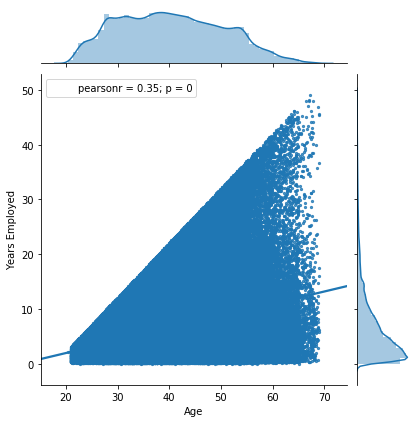

In [41]:
age = application_train.DAYS_BIRTH[application_train['DAYS_EMPLOYED'].notnull()]/ -365.25
years_employed = application_train['DAYS_EMPLOYED'].dropna()/ -365.25
#print(age.size)
#print(years_employed.size)
#print(application_train.DAYS_BIRTH.size)
#print(application_train['DAYS_EMPLOYED'].dropna().size)
ax = sns.jointplot(x=age, y=years_employed, kind= "reg",scatter_kws={"s": 5})
#ax.set_title("Correlation between Age and Years Employed")
ax.set_axis_labels('Age', 'Years Employed')
plt.show();


**Data Modeling**

Prepare dataset for modeling. Create X,y format and split in train and test taking into account the unbalanced TARGET

In [49]:
X = application_train.iloc[:,pd.np.r_[0, 2:122]]
y=application_train['TARGET']
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, stratify = y, random_state = 1)

(307511, 121)
(307511,)


Transform some features. For the numeric features impute missing values by column and standardize. We are also getting the categorical variables. We should transform them to use them in Random Forest, but for now we will leave them out.

In [62]:
X_objects = X.select_dtypes(include=['object'])


In [55]:
X.DAYS_EMPLOYED.replace(365243,np.NaN,inplace=True)
X_numeric = X.select_dtypes(include=['int64','float64'])
imp = Imputer(strategy="mean", axis=0)
scale = StandardScaler()
X_std = scale.fit_transform(imp.fit_transform(X_numeric))
print(X_std.shape)
print(y.shape)

(307511, 105)
(307511,)


**Train a Random Forest Classifier and use it to classify on the test set**

In [56]:


X_train, X_test, y_train, y_test = train_test_split(X_std,y, test_size = 0.25, stratify = y, random_state = 1)
rf = RandomForestClassifier(n_estimators=100, # 100 árboles
                            criterion="gini", # Igual que en el DecisionTreeClassifier
                            max_depth=3, # Igual que en el DecisionTreeClassifier
                            min_samples_split=10,
                            min_samples_leaf=5,
                            bootstrap=True
                            )
rf.fit(X=X_train, y=y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [61]:
test_res=rf.predict(X_test)
# Create confusion matrix
pd.crosstab(y_test, test_res, rownames=['Actual TARGET'], colnames=['Predicted TARGET'])

Predicted TARGET,0
Actual TARGET,
0,70672
1,6206


So we can see that the random forest classifier actually predicts all test samples as the majority TARGET class 0. This is a problem of unbalanced datasets. Some possible solutions include:<br/> 
-downsampling to get even classes, <br/>
-oversampling using for example SMOTE synthetic oversampling of the minority class <br/><br/>
Additionally we should include the categorical features in the analysis